In [1]:
#数据预处理
%matplotlib inline
import tensorflow as tf
import numpy as np
import os
from time import time
from scipy.signal import welch
from scipy.interpolate import  interp1d as interp
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import scale
from sklearn.model_selection import StratifiedKFold 
from tensorflow.keras.utils import Progbar
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
class Preprocessing(object):
    """
    对序列进行提取特征等预处理
    为了可能处理变长序列,因此输入为list
    """
    def __init__(self,with_label=True):
        self.with_label=with_label
    def __call__(self,sequence):
        for i in range(len(sequence)):
            time_point=np.expand_dims(sequence[i][0],axis=0)
            if self.with_label:
                label=np.expand_dims(sequence[i][-1],axis=0)
                new_sequence=self.for_each(sequence[i][1:-1])
                sequence[i]=np.concatenate([time_point,new_sequence,label],axis=0)
            else:
                new_sequence=self.for_each(sequence[i][1:])
                sequence[i]=np.concatenate([time_point,new_sequence],axis=0)
        sequence=self.for_all(sequence)
        return sequence
    def smooth(self,array,decay_rate=0.9):
        _smooth=np.zeros(array.shape)
        for i in range(1,len(array)-1):
            decay=min(decay_rate,(i+1)/(i+10))
            _smooth[i]=_smooth[i-1]*decay+(1-decay)*array[i]
        return _smooth
    def for_all(self,sequence):#变长序列可以numpy吗#
        return sequence
        mean=np.zeros(shape=sequence[0].shape[0])
        std=np.zeros(shape=sequence[0].shape[0])
        lenth=len(sequence)
        for index in range(lenth):
            if self.with_label:
                _range=range(1,sequence[index].shape[0]-1)
            else:
                _range=range(1,sequence[index].shape[0])
            for i in _range:
                mean[i]+=sequence[index][i].mean()/lenth
                std[i]+=sequence[index][i].std()/lenth
        for index in range(lenth):
            if self.with_label:
                _range=range(1,sequence[index].shape[0]-1)
            else:
                _range=range(1,sequence[index].shape[0])
            for i in _range:
                sequence[index][i]=(sequence[index][i]-mean[i])/std[i]
        return sequence
    def for_each(self,sequence):
        acc=(sequence[0]**2+sequence[1]**2+sequence[2]**2)**0.5
        acc=np.expand_dims(acc,axis=0)
        acc_g=(sequence[3]**2+sequence[4]**2+sequence[5]**2)**0.5
        acc_g=np.expand_dims(acc_g,axis=0)
        sequence=np.concatenate([sequence,acc,acc_g],axis=0)
        return sequence

In [2]:
#加载数据
class DatasetLoader(object):
    def __init__(self,csv_file,with_label=True,num_classes=19):
        self.csv_file=csv_file
        self.with_label=with_label
        self.format="channel_last"
        self.split=False
        self.names=self.get_feature_names()
        self.num_classes=num_classes
        self.data_split=False
    def get_feature_names(self):
         with open(self.csv_file) as f:
            examples={}
            names=f.readline().split(',')[1:]
            names[-1]=names[-1][:-1]
            return names
    def make_numpy(self,num_interpolation=200,with_label=True):
        '''将数据读取并保存为Numpy数组
               Args:
                 num_interpolation:差值法采样点个数
                 with_label：是否带标签
               Returns:
                 A list,shape=[num_examples,keys,length]
        '''
        #数据读取
        if self.csv_file is None:
            raise ValueError("sub dataset cannnot get numpy data")
        print("Loading date...")
        line={}
        with open(self.csv_file) as f:
            examples={}
            names=f.readline().split(',')[1:]
            names[-1]=names[-1][:-1]
            while True:
                try:
                    line=f.readline().split(",")
                    if line is None:
                        break
                    for i in range(len(line)):
                        line[i]=eval(line[i])
                    if not line[0] in examples:
                        examples[line[0]]=[]
                    examples[line[0]].append(line[1:])
                except:
                    break
        print("done")
        #格式转换            
        for i in range(len(examples)):
            examples[i]=np.array(examples[i]).transpose([1,0])
        self.examples=examples=list(examples.values())
        return self
    def resample(self,num_interpolation=200):
        examples=self.examples
        print("interpolate")
        bar=Progbar(len(examples))#进度条
        if num_interpolation and num_interpolation is not None:
            for i in range(len(examples)):
                range_len=examples[i][0][-1]-examples[i][0][0]
                range_start=examples[i][0][0]
                range_interval=range_len/num_interpolation
                interp_x=[range_start+range_interval*i for i in range(num_interpolation)]
                interp_data=[interp_x]
                for feature_id in range(1,len(self.names)):
                    try:
                        interp_f=interp(examples[i][0],examples[i][feature_id],kind="cubic")
                        interp_data.append([interp_f(x)for x in interp_x])
                    except:
                        raise ValueError("%d %d"%(i,feature_id),examples[i])
                bar.update(i)
                examples[i]=np.array(interp_data)
        print("\ndone")
        #数据预处理
        preprocession=Preprocessing(with_label=self.with_label)
        examples=preprocession(examples)
        self.examples=np.array(examples,dtype="float32")    
        if self.with_label:
            self.y=self.examples[::,-1,0].tolist()
            self.x=self.examples[::,1:-1,::]
        else:
            self.x=self.examples[::,1:,::]
        return self
    def apply_class_weights(self):
        weights=np.zeros([self.num_classes])
        for i in range(len(weights)):
            weights[i]=(self.examples[::,-1:,0]==i).sum()
        return weights/weights.sum()
    def data_format(string="channel_last"):
        if not string in ["channel_first","channel_last"]:
            raise ValueError("either channel_last or channel_first are supported")
        self.format=string
    def apply_data(self):
        if self.with_label:
            if self.split:
                if self.format=="channel_first":
                    return self.x_train,self.y_train,self.x_test,self.y_test
                else:
                    return self.x_train.transpose([0,2,1]),self.y_train,self.x_test.transpose([0,2,1]),self.y_test
                    
            else:
                if self.format=="channel_first":
                    return self.x,self.y
                else:
                    return self.x.transpose([0,2,1]),self.y
        else:
            if self.format=="channel_first":
                return self.x
            else:
                return self.x.transpose([0,2,1])
if False:
    train_csv_file="data\\sensor_train.csv"
    test_csv_file="data\\sensor_test.csv"

    dataset=DatasetLoader(train_csv_file)
    print(dataset.names)
    data=dataset.make_numpy()
    data=dataset.resample(num_interpolation=60)
    x_train,y_train=data.apply_data()

plt.plot(x_train[5,::,8])


NameError: name 'x_train' is not defined

In [12]:
#metrics
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
def single_score(y, y_pred):
    # 数值ID与行为编码的对应关系
    mapping = {0: 'A_0', 1: 'A_1', 2: 'A_2', 3: 'A_3', 
        4: 'D_4', 5: 'A_5', 6: 'B_1',7: 'B_5', 
        8: 'B_2', 9: 'B_3', 10: 'B_0', 11: 'A_6', 
        12: 'C_1', 13: 'C_3', 14: 'C_0', 15: 'B_6', 
        16: 'C_2', 17: 'C_5', 18: 'C_6'}
    # 将行为ID转为编码
    code_y, code_y_pred = mapping[y], mapping[y_pred]
    if code_y == code_y_pred: #编码完全相同得分1.0
        return 1.0
    elif code_y.split("_")[0] == code_y_pred.split("_")[0]: #编码仅字母部分相同得分1.0/7
        return 1.0/7
    elif code_y.split("_")[1] == code_y_pred.split("_")[1]: #编码仅数字部分相同得分1.0/3
        return 1.0/3
    else:
        return 0.0
def py_score(y_true,y_pred):
    y_true=np.argmax(y_true,axis=-1)
    y_pred=np.argmax(y_pred,axis=-1)
    scores=[]
    for i in range(len(y_true)):
        scores.append(single_score(y_true[i],y_pred[i]))
    mean_score=np.array(scores,dtype="float32").mean()
    return mean_score,mean_score
def score(y_true,y_pred):
    """线上评测所使用的评测方法
    Args:
      y_true:one_hot编码的标签
      y_pred:网络类别置信度预测
    Returns:
      Tensor标量
    """
    mean_score=tf.py_func(py_score,[y_true,y_pred],[tf.float32,tf.float32])[0]
    return tf.reshape(mean_score,shape=())

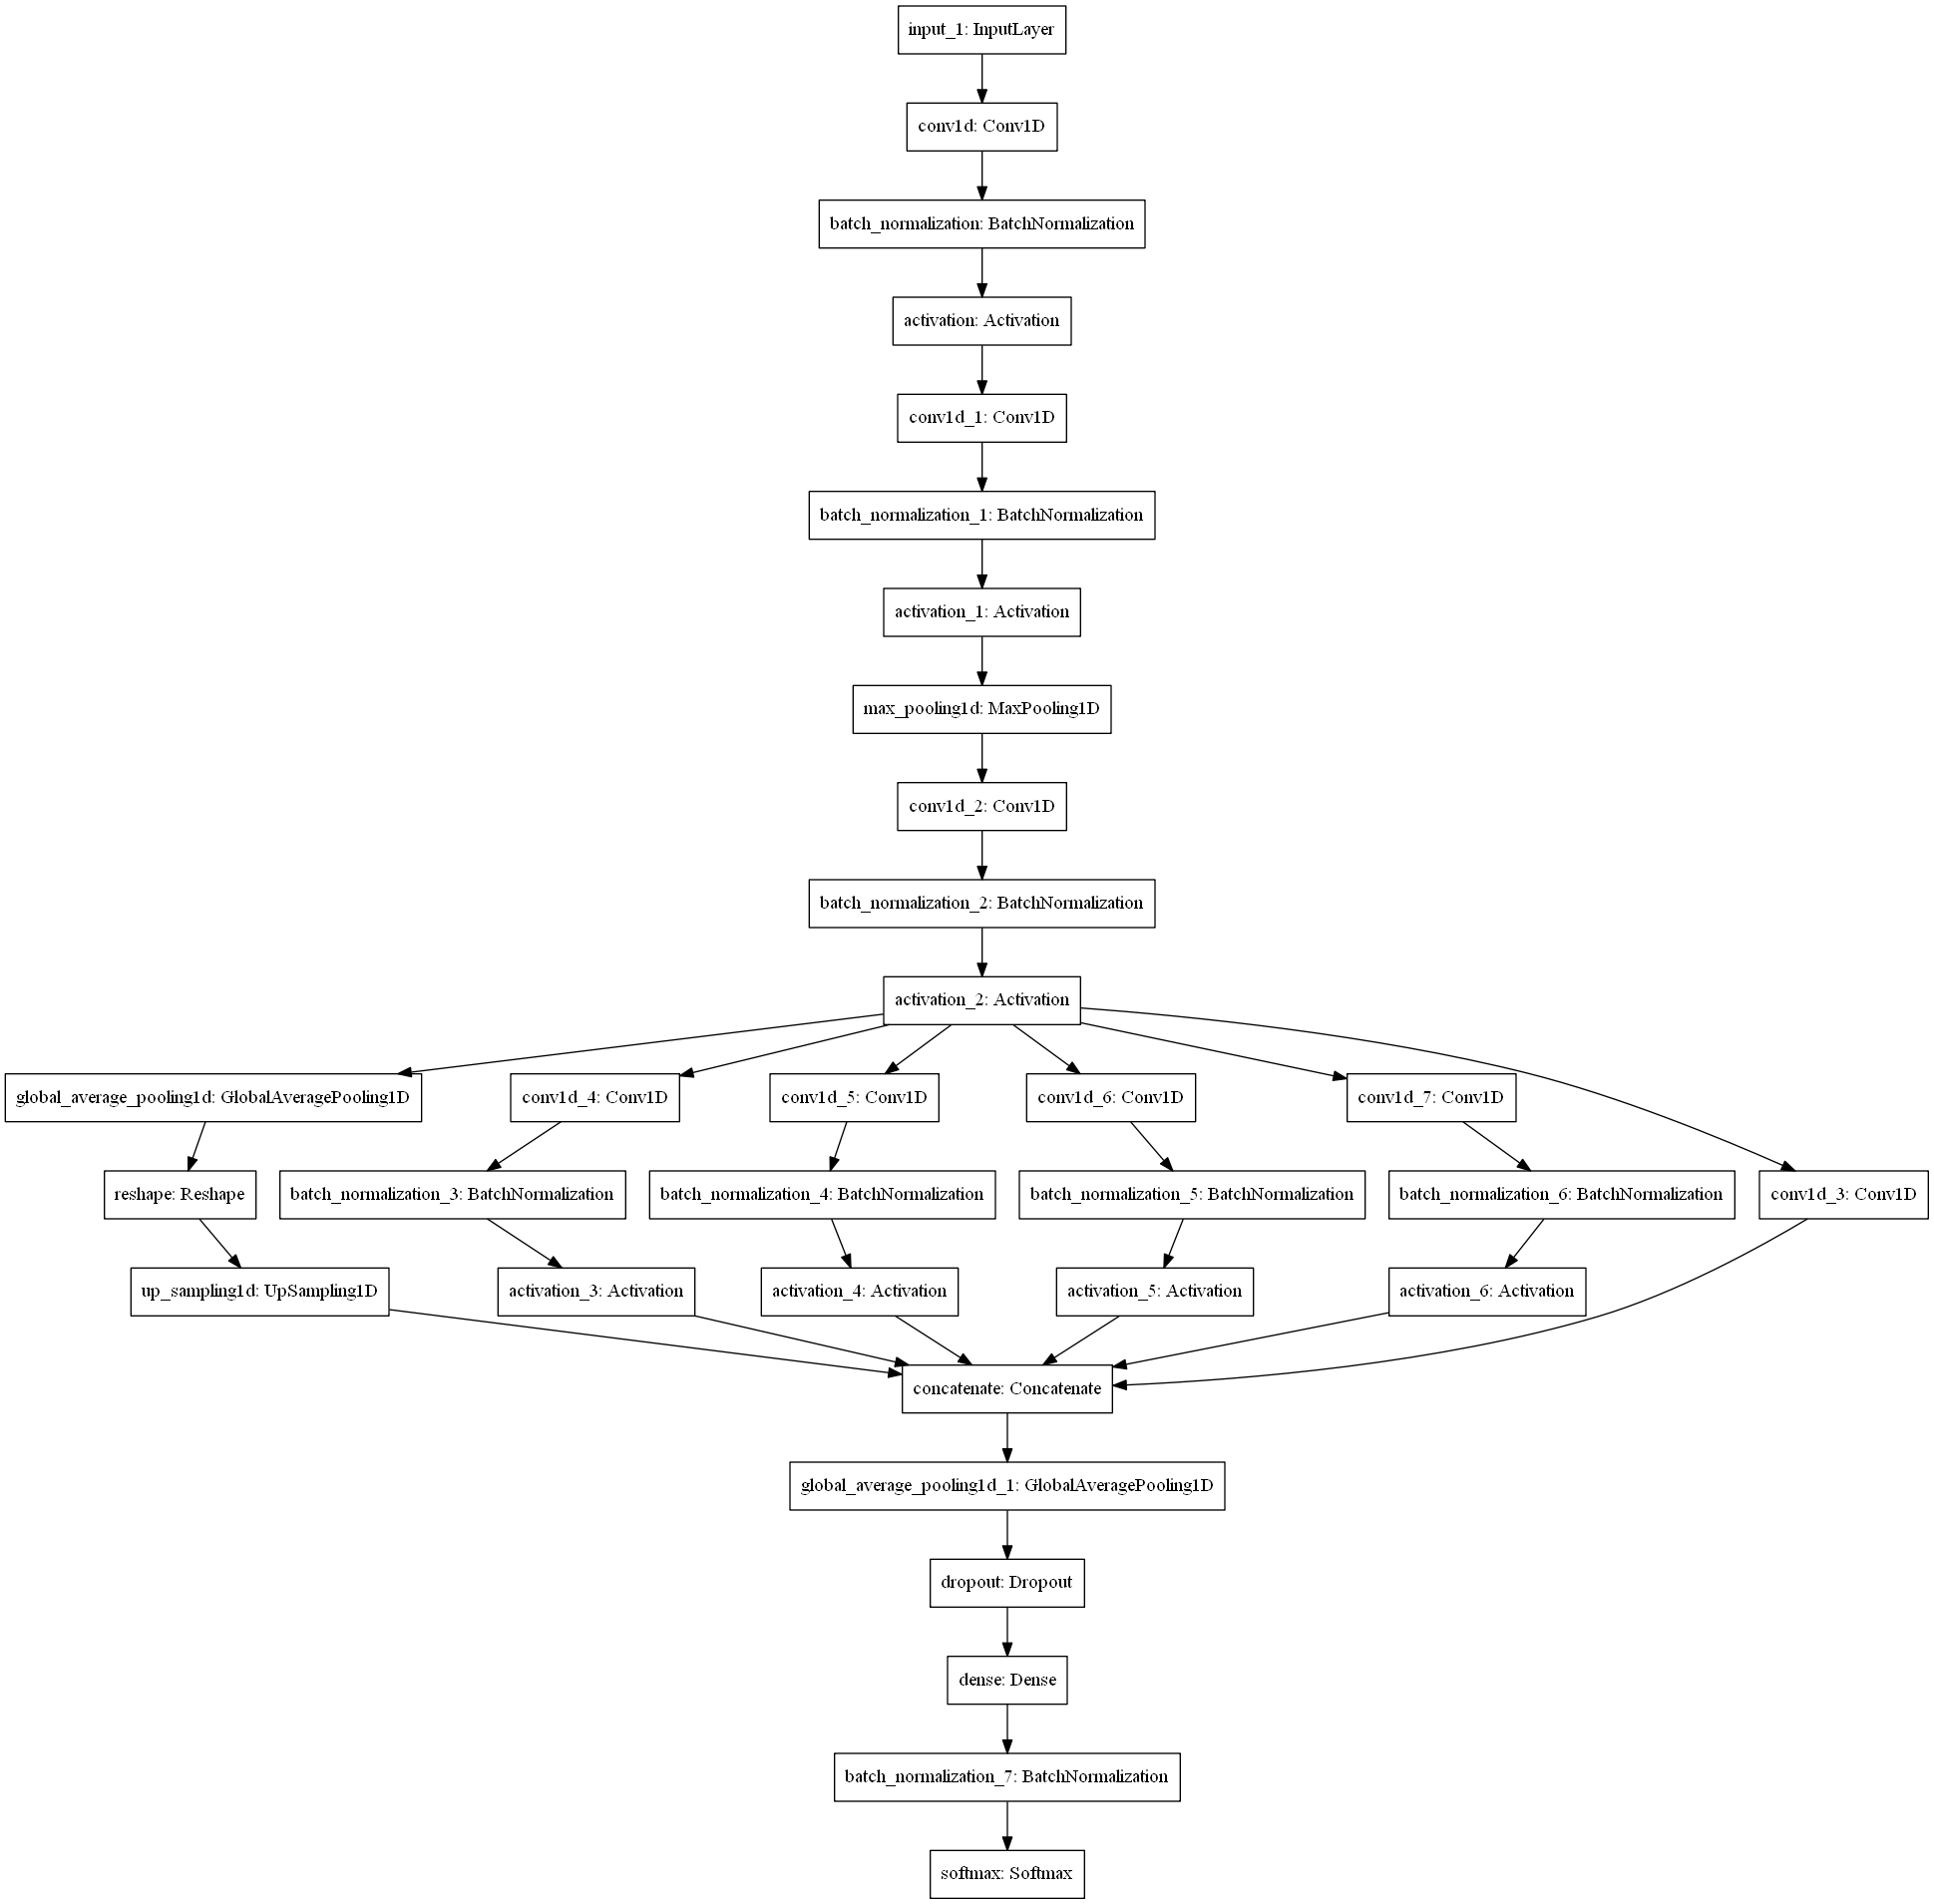

In [42]:
#网络结构
import tensorflow as tf
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import UpSampling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Softmax
from tensorflow.keras.layers import Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
tf.reset_default_graph()
class ASPP(object):
    def __init__(self,filters,kernel_size,activation,dilation_rates=[1,2,5,9]):
        self.filters=filters
        self.kernel_size=kernel_size
        self.dilation_rates=dilation_rates
        self.activation=activation
    def branch(self,tensor,dilation_rate):
        x=Conv1D(self.filters,self.kernel_size,1,padding="same",kernel_regularizer=l2(0.011),
                 activation=self.activation,dilation_rate=dilation_rate)(tensor)
        x=BatchNormalization()(x)
        x=Activation(self.activation)(x)
        return x
    def pool(self,tensor):
        shape=tensor.shape.as_list()#[batch,lenth,channels]
        scaler=GlobalAveragePooling1D()(tensor)#[batch,channels]
        scaler=Reshape([1]+[shape[2]])(scaler)
        scaler=UpSampling1D(shape[1])(scaler)
        return scaler
    def __call__(self,tensor):
        output=[Conv1D(self.filters,1,1,padding="same",activation=self.activation,kernel_regularizer=l2(0.011))(tensor)]
        output.append(self.pool(tensor))
        for rate in self.dilation_rates:
            output.append(self.branch(tensor,rate))
        output=tf.keras.layers.concatenate(output)
        return output
def CNN(inputs,num_classes):
    x=Conv1D(64,3,1,padding="same",kernel_regularizer=l2(0.01))(inputs)
    x=BatchNormalization()(x)
    x=Activation(tf.nn.relu)(x)
    
    x=Conv1D(128,3,1,padding="same",kernel_regularizer=l2(0.01))(x)
    x=BatchNormalization()(x)
    x=Activation(tf.nn.relu)(x)
    
    x=MaxPooling1D(2,padding="same")(x)
    
    x=Conv1D(256,3,1,padding="same",kernel_regularizer=l2(0.01))(x)
    x=BatchNormalization()(x)
    x=Activation(tf.nn.relu)(x)
    
    x=ASPP(128,3,activation=tf.nn.relu)(x)
    
    x=GlobalAveragePooling1D()(x)
    x=Dropout(0.4)(x)

    x=Dense(num_classes,kernel_regularizer=l2(0.01))(x)
    x=BatchNormalization()(x)
    x=Softmax()(x)
    return x
inputs=Input(shape=[200,8])
outputs=CNN(inputs,num_classes=19)
tf.keras.utils.plot_model(Model(inputs,outputs))

## 类别权重

class_weight：字典，将不同的类别映射为不同的权值，该参数用来在训练过程中调整损失函数（只能用于训练）。该参数在处理非平衡的训练数据（某些类的训练样本数很少）时，可以使得损失函数对样本数不足的数据更加关注。

In [1]:
#加载数据和模型
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
tf.reset_default_graph()
csv_file="data\\sensor_train.csv"
test_csv_file="data\\sensor_test.csv"
filepath='best_weights_aspp_raw'
batch_size=24
config=tf.ConfigProto()
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
sess=tf.Session(config=config)
K.set_session(sess)
if False:
    dataset=DatasetLoader(csv_file,with_label=True,num_classes=19)
    dataset=dataset.make_numpy()
    dataset=dataset.resample(num_interpolation=64)
    x,y=dataset.apply_data()
    class_weight=dataset.apply_class_weights()
    dataset=DatasetLoader(test_csv_file,with_label=False)
    data=dataset.make_numpy()
    data=dataset.resample(num_interpolation=64)
    x_val=data.apply_data()
plt.plot(x[5])
plt.legend(["1","2","3","4","5","6","7","8"])
plt.show()

NameError: name 'tf' is not defined

In [44]:
(1-class_weight)**3

array([0.90409104, 0.74687257, 0.84099484, 0.86953634, 0.83150041,
       0.86542005, 0.72474282, 0.90601573, 0.87103641, 0.88651163,
       0.90601573, 0.82641776, 0.72740161, 0.88499385, 0.94905292,
       0.81595538, 0.86467304, 0.89718473, 0.86467304])

In [45]:
from tensorflow.keras.utils import to_categorical
config=tf.ConfigProto()
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
sess=tf.Session(config=config)
K.set_session(sess)
kfold = StratifiedKFold(5, shuffle=True,random_state=20001026)
proba_t = np.zeros((7500, 19))
train_score=[]
test_score=[]
for fold,(xx,yy) in enumerate(kfold.split(x,y)):
    tf.reset_default_graph()
    inputs=Input(shape=[64,8])
    outputs=CNN(inputs,num_classes=19)
    model=Model(inputs=inputs,outputs=outputs)
    _y=to_categorical(y,19)
    plateau = ReduceLROnPlateau(monitor="val_score",
                                verbose=1,
                                mode='max',
                                factor=0.5,
                                patience=6)
    early_stopping = EarlyStopping(monitor='val_acc',
                                   verbose=1,
                                   mode='max',
                                   patience=15)
    checkpoint = ModelCheckpoint(f'fold{fold}.h5',
                                 monitor='val_score',
                                 verbose=1,
                                 mode='max',
                                 save_best_only=True)
    model.compile(loss="categorical_crossentropy",optimizer=Adam(),metrics=["acc",score])
    trained_model=model.fit(
            x[xx],
            _y[xx],
            batch_size=batch_size,
            class_weight=(1-class_weight)**3,
            shuffle=True,
            validation_data=(x[yy],_y[yy]),
            epochs=300,
            callbacks=[plateau,early_stopping,checkpoint])
    model.load_weights(f'fold{fold}.h5')
    proba_t += model.predict(x_val, verbose=0, batch_size=1024) / 5.
    train_score.append(np.array(trained_model.history["score"]).max())
    test_score.append(np.array(trained_model.history["val_score"]).max())
label=proba_t.argmax(axis=1)
print("on_train_set:",np.array(train_score))
print("average:",np.array(train_score).mean())
print("on_test_set:",np.array(test_score))
print("average:",np.array(test_score).mean())
print("done")

Train on 5825 samples, validate on 1467 samples
Epoch 1/300
5568/5825 [===========================>..] - ETA: 0s - loss: 8.7624 - acc: 0.3346 - score: 0.4169
Epoch 00001: val_score improved from -inf to 0.29866, saving model to fold0.h5
5825/5825 [==============================] - 3s 589us/sample - loss: 8.5832 - acc: 0.3360 - score: 0.4249 - val_loss: 5.3648 - val_acc: 0.2052 - val_score: 0.2987
Epoch 2/300
5696/5825 [============================>.] - ETA: 0s - loss: 3.3922 - acc: 0.4082 - score: 0.4872
Epoch 00002: val_score did not improve from 0.29866
5825/5825 [==============================] - 1s 203us/sample - loss: 3.3766 - acc: 0.4093 - score: 0.4827 - val_loss: 3.6843 - val_acc: 0.1513 - val_score: 0.2675
Epoch 3/300
5568/5825 [===========================>..] - ETA: 0s - loss: 2.4971 - acc: 0.4388 - score: 0.5150
Epoch 00003: val_score did not improve from 0.29866
5825/5825 [==============================] - 1s 205us/sample - loss: 2.4898 - acc: 0.4395 - score: 0.5144 - val_l

5632/5825 [============================>.] - ETA: 0s - loss: 1.4835 - acc: 0.5985 - score: 0.6585
Epoch 00025: val_score did not improve from 0.54114
5825/5825 [==============================] - 1s 204us/sample - loss: 1.4865 - acc: 0.5969 - score: 0.6515 - val_loss: 1.9263 - val_acc: 0.4588 - val_score: 0.5397
Epoch 26/300
5696/5825 [============================>.] - ETA: 0s - loss: 1.4072 - acc: 0.6192 - score: 0.6758
Epoch 00026: val_score improved from 0.54114 to 0.57223, saving model to fold0.h5
5825/5825 [==============================] - 1s 220us/sample - loss: 1.4066 - acc: 0.6184 - score: 0.6678 - val_loss: 1.8704 - val_acc: 0.5003 - val_score: 0.5722
Epoch 27/300
5696/5825 [============================>.] - ETA: 0s - loss: 1.3797 - acc: 0.6254 - score: 0.6817
Epoch 00027: val_score improved from 0.57223 to 0.57259, saving model to fold0.h5
5825/5825 [==============================] - 1s 215us/sample - loss: 1.3840 - acc: 0.6228 - score: 0.6722 - val_loss: 1.7872 - val_acc: 0.

Epoch 73/300
5568/5825 [===========================>..] - ETA: 0s - loss: 0.6246 - acc: 0.8784 - score: 0.8967
Epoch 00073: val_score did not improve from 0.81704
5825/5825 [==============================] - 1s 203us/sample - loss: 0.6248 - acc: 0.8779 - score: 0.8866 - val_loss: 0.9565 - val_acc: 0.7682 - val_score: 0.8033
Epoch 74/300
5824/5825 [============================>.] - ETA: 0s - loss: 0.6012 - acc: 0.8982 - score: 0.9136
Epoch 00074: val_score did not improve from 0.81704
5825/5825 [==============================] - 1s 204us/sample - loss: 0.6016 - acc: 0.8980 - score: 0.9036 - val_loss: 0.9477 - val_acc: 0.7689 - val_score: 0.8053
Epoch 75/300
5632/5825 [============================>.] - ETA: 0s - loss: 0.5792 - acc: 0.8972 - score: 0.9144
Epoch 00075: val_score did not improve from 0.81704
5825/5825 [==============================] - 1s 203us/sample - loss: 0.5831 - acc: 0.8968 - score: 0.9058 - val_loss: 0.9349 - val_acc: 0.7771 - val_score: 0.8116
Epoch 76/300
5696/5825

5824/5825 [============================>.] - ETA: 0s - loss: 0.4494 - acc: 0.9478 - score: 0.9556
Epoch 00121: val_score did not improve from 0.83465
5825/5825 [==============================] - 1s 202us/sample - loss: 0.4499 - acc: 0.9476 - score: 0.9468 - val_loss: 0.8458 - val_acc: 0.8003 - val_score: 0.8323
Epoch 122/300
5568/5825 [===========================>..] - ETA: 0s - loss: 0.4399 - acc: 0.9445 - score: 0.9532
Epoch 00122: val_score improved from 0.83465 to 0.83475, saving model to fold0.h5
5825/5825 [==============================] - 1s 214us/sample - loss: 0.4429 - acc: 0.9435 - score: 0.9422 - val_loss: 0.8498 - val_acc: 0.8030 - val_score: 0.8347
Epoch 123/300
5568/5825 [===========================>..] - ETA: 0s - loss: 0.4387 - acc: 0.9474 - score: 0.9565
Epoch 00123: val_score did not improve from 0.83475
5825/5825 [==============================] - 1s 203us/sample - loss: 0.4415 - acc: 0.9456 - score: 0.9483 - val_loss: 0.8486 - val_acc: 0.8010 - val_score: 0.8329
Epo

5632/5831 [===========================>..] - ETA: 0s - loss: 1.0795 - acc: 0.7209 - score: 0.7640
Epoch 00046: val_score did not improve from 0.71407
5831/5831 [==============================] - 1s 210us/sample - loss: 1.0821 - acc: 0.7194 - score: 0.7594 - val_loss: 1.3973 - val_acc: 0.6283 - val_score: 0.6879
Epoch 47/300
5824/5831 [============================>.] - ETA: 0s - loss: 1.0902 - acc: 0.7126 - score: 0.7575
Epoch 00047: val_score did not improve from 0.71407
5831/5831 [==============================] - 1s 207us/sample - loss: 1.0902 - acc: 0.7129 - score: 0.7601 - val_loss: 1.4017 - val_acc: 0.6153 - val_score: 0.6677
Epoch 48/300
5568/5831 [===========================>..] - ETA: 0s - loss: 1.0766 - acc: 0.7141 - score: 0.7587
Epoch 00048: val_score did not improve from 0.71407
5831/5831 [==============================] - 1s 203us/sample - loss: 1.0738 - acc: 0.7155 - score: 0.7581 - val_loss: 1.4172 - val_acc: 0.6071 - val_score: 0.6645
Epoch 49/300
5824/5831 [===========

5632/5831 [===========================>..] - ETA: 0s - loss: 0.7143 - acc: 0.8477 - score: 0.8716
Epoch 00070: val_score did not improve from 0.81214
5831/5831 [==============================] - 1s 206us/sample - loss: 0.7170 - acc: 0.8463 - score: 0.8696 - val_loss: 0.9456 - val_acc: 0.7591 - val_score: 0.7945
Epoch 71/300
5824/5831 [============================>.] - ETA: 0s - loss: 0.7016 - acc: 0.8583 - score: 0.8806
Epoch 00071: val_score did not improve from 0.81214
5831/5831 [==============================] - 1s 211us/sample - loss: 0.7030 - acc: 0.8580 - score: 0.8773 - val_loss: 0.8859 - val_acc: 0.7803 - val_score: 0.8118
Epoch 72/300
5696/5831 [============================>.] - ETA: 0s - loss: 0.7062 - acc: 0.8553 - score: 0.8778
Epoch 00072: val_score improved from 0.81214 to 0.82140, saving model to fold1.h5
5831/5831 [==============================] - 1s 215us/sample - loss: 0.7064 - acc: 0.8561 - score: 0.8771 - val_loss: 0.9047 - val_acc: 0.7912 - val_score: 0.8214
Epoch

5824/5831 [============================>.] - ETA: 0s - loss: 0.5101 - acc: 0.9241 - score: 0.9364
Epoch 00118: val_score did not improve from 0.84525
5831/5831 [==============================] - 1s 196us/sample - loss: 0.5106 - acc: 0.9240 - score: 0.9355 - val_loss: 0.8035 - val_acc: 0.8152 - val_score: 0.8429
Epoch 119/300
5824/5831 [============================>.] - ETA: 0s - loss: 0.5080 - acc: 0.9241 - score: 0.9365
Epoch 00119: val_score did not improve from 0.84525
5831/5831 [==============================] - 1s 197us/sample - loss: 0.5086 - acc: 0.9239 - score: 0.9343 - val_loss: 0.8048 - val_acc: 0.8131 - val_score: 0.8396
Epoch 120/300
5824/5831 [============================>.] - ETA: 0s - loss: 0.5220 - acc: 0.9191 - score: 0.9319
Epoch 00120: val_score did not improve from 0.84525
5831/5831 [==============================] - 1s 198us/sample - loss: 0.5226 - acc: 0.9191 - score: 0.9313 - val_loss: 0.8017 - val_acc: 0.8138 - val_score: 0.8414
Epoch 121/300
5760/5831 [========

Epoch 24/300
5760/5834 [============================>.] - ETA: 0s - loss: 1.4487 - acc: 0.6054 - score: 0.6647
Epoch 00024: val_score did not improve from 0.60244
5834/5834 [==============================] - 1s 196us/sample - loss: 1.4484 - acc: 0.6047 - score: 0.6627 - val_loss: 1.8752 - val_acc: 0.4822 - val_score: 0.5524
Epoch 25/300
5824/5834 [============================>.] - ETA: 0s - loss: 1.4261 - acc: 0.6133 - score: 0.6718
Epoch 00025: val_score did not improve from 0.60244
5834/5834 [==============================] - 1s 196us/sample - loss: 1.4273 - acc: 0.6128 - score: 0.6690 - val_loss: 1.8281 - val_acc: 0.4870 - val_score: 0.5422
Epoch 26/300
5824/5834 [============================>.] - ETA: 0s - loss: 1.4272 - acc: 0.6180 - score: 0.6759
Epoch 00026: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00026: val_score did not improve from 0.60244
5834/5834 [==============================] - 1s 197us/sample - loss: 1.4283 - acc: 0.6178 - score: 0.674

5824/5834 [============================>.] - ETA: 0s - loss: 0.6015 - acc: 0.8985 - score: 0.9146
Epoch 00072: val_score did not improve from 0.82184
5834/5834 [==============================] - 1s 203us/sample - loss: 0.6034 - acc: 0.8977 - score: 0.9096 - val_loss: 0.9093 - val_acc: 0.7874 - val_score: 0.8181
Epoch 73/300
5760/5834 [============================>.] - ETA: 0s - loss: 0.5906 - acc: 0.9021 - score: 0.9184
Epoch 00073: val_score did not improve from 0.82184
5834/5834 [==============================] - 1s 200us/sample - loss: 0.5912 - acc: 0.9016 - score: 0.9162 - val_loss: 0.9048 - val_acc: 0.7860 - val_score: 0.8171
Epoch 74/300
5760/5834 [============================>.] - ETA: 0s - loss: 0.5848 - acc: 0.9090 - score: 0.9247
Epoch 00074: val_score did not improve from 0.82184
5834/5834 [==============================] - 1s 200us/sample - loss: 0.5894 - acc: 0.9073 - score: 0.9189 - val_loss: 0.9005 - val_acc: 0.7826 - val_score: 0.8153
Epoch 75/300
5760/5834 [===========

5568/5837 [===========================>..] - ETA: 0s - loss: 1.7352 - acc: 0.5271 - score: 0.5968
Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00015: val_score did not improve from 0.51780
5837/5837 [==============================] - 1s 211us/sample - loss: 1.7356 - acc: 0.5258 - score: 0.5937 - val_loss: 2.0984 - val_acc: 0.4096 - val_score: 0.4863
Epoch 16/300
5824/5837 [============================>.] - ETA: 0s - loss: 1.5957 - acc: 0.5677 - score: 0.6309
Epoch 00016: val_score improved from 0.51780 to 0.60905, saving model to fold3.h5
5837/5837 [==============================] - 1s 205us/sample - loss: 1.5966 - acc: 0.5674 - score: 0.6294 - val_loss: 1.8466 - val_acc: 0.5416 - val_score: 0.6091
Epoch 17/300
5760/5837 [============================>.] - ETA: 0s - loss: 1.5662 - acc: 0.5649 - score: 0.6272
Epoch 00017: val_score did not improve from 0.60905
5837/5837 [==============================] - 1s 197us/sample - loss: 1.5650 - acc: 0.56

5760/5837 [============================>.] - ETA: 0s - loss: 1.0927 - acc: 0.7255 - score: 0.7671
Epoch 00039: val_score did not improve from 0.69048
5837/5837 [==============================] - 1s 195us/sample - loss: 1.0934 - acc: 0.7257 - score: 0.7646 - val_loss: 1.4389 - val_acc: 0.6048 - val_score: 0.6611
Epoch 40/300
5824/5837 [============================>.] - ETA: 0s - loss: 1.0701 - acc: 0.7340 - score: 0.7745
Epoch 00040: val_score improved from 0.69048 to 0.72671, saving model to fold3.h5
5837/5837 [==============================] - 1s 207us/sample - loss: 1.0709 - acc: 0.7334 - score: 0.7720 - val_loss: 1.2603 - val_acc: 0.6708 - val_score: 0.7267
Epoch 41/300
5824/5837 [============================>.] - ETA: 0s - loss: 1.0707 - acc: 0.7363 - score: 0.7765
Epoch 00041: val_score did not improve from 0.72671
5837/5837 [==============================] - 1s 194us/sample - loss: 1.0710 - acc: 0.7363 - score: 0.7768 - val_loss: 1.4503 - val_acc: 0.6082 - val_score: 0.6655
Epoch

5824/5837 [============================>.] - ETA: 0s - loss: 0.5214 - acc: 0.9277 - score: 0.9391
Epoch 00087: val_score improved from 0.83616 to 0.83921, saving model to fold3.h5
5837/5837 [==============================] - 1s 206us/sample - loss: 0.5235 - acc: 0.9274 - score: 0.9376 - val_loss: 0.8649 - val_acc: 0.8110 - val_score: 0.8392
Epoch 88/300
5632/5837 [===========================>..] - ETA: 0s - loss: 0.5132 - acc: 0.9293 - score: 0.9401
Epoch 00088: val_score did not improve from 0.83921
5837/5837 [==============================] - 1s 197us/sample - loss: 0.5166 - acc: 0.9282 - score: 0.9386 - val_loss: 0.8720 - val_acc: 0.8082 - val_score: 0.8379
Epoch 89/300
5568/5837 [===========================>..] - ETA: 0s - loss: 0.5168 - acc: 0.9305 - score: 0.9414
Epoch 00089: val_score improved from 0.83921 to 0.84068, saving model to fold3.h5
5837/5837 [==============================] - 1s 210us/sample - loss: 0.5186 - acc: 0.9291 - score: 0.9388 - val_loss: 0.8620 - val_acc: 0.

5824/5837 [============================>.] - ETA: 0s - loss: 0.4652 - acc: 0.9475 - score: 0.9558
Epoch 00111: val_score did not improve from 0.84694
5837/5837 [==============================] - 1s 191us/sample - loss: 0.4668 - acc: 0.9467 - score: 0.9524 - val_loss: 0.8454 - val_acc: 0.8110 - val_score: 0.8386
Epoch 112/300
5824/5837 [============================>.] - ETA: 0s - loss: 0.4654 - acc: 0.9463 - score: 0.9549
Epoch 00112: val_score did not improve from 0.84694
5837/5837 [==============================] - 1s 189us/sample - loss: 0.4671 - acc: 0.9455 - score: 0.9517 - val_loss: 0.8455 - val_acc: 0.8124 - val_score: 0.8397
Epoch 00112: early stopping
Train on 5841 samples, validate on 1451 samples
Epoch 1/300
5824/5841 [============================>.] - ETA: 0s - loss: 8.5500 - acc: 0.3278 - score: 0.4082
Epoch 00001: val_score improved from -inf to 0.21126, saving model to fold4.h5
5841/5841 [==============================] - 3s 487us/sample - loss: 8.5390 - acc: 0.3277 - sco

Epoch 23/300
5824/5841 [============================>.] - ETA: 0s - loss: 1.4581 - acc: 0.5958 - score: 0.6558
Epoch 00023: val_score did not improve from 0.55896
5841/5841 [==============================] - 1s 195us/sample - loss: 1.4593 - acc: 0.5958 - score: 0.6558 - val_loss: 2.8163 - val_acc: 0.3501 - val_score: 0.4401
Epoch 24/300
5824/5841 [============================>.] - ETA: 0s - loss: 1.4251 - acc: 0.6219 - score: 0.6782
Epoch 00024: val_score did not improve from 0.55896
5841/5841 [==============================] - 1s 195us/sample - loss: 1.4266 - acc: 0.6220 - score: 0.6783 - val_loss: 2.0572 - val_acc: 0.4452 - val_score: 0.5172
Epoch 25/300
5824/5841 [============================>.] - ETA: 0s - loss: 1.4164 - acc: 0.6120 - score: 0.6716
Epoch 00025: val_score improved from 0.55896 to 0.56991, saving model to fold4.h5
5841/5841 [==============================] - 1s 205us/sample - loss: 1.4185 - acc: 0.6109 - score: 0.6683 - val_loss: 1.7595 - val_acc: 0.4990 - val_score:

5824/5841 [============================>.] - ETA: 0s - loss: 0.6907 - acc: 0.8620 - score: 0.8846
Epoch 00071: val_score did not improve from 0.77186
5841/5841 [==============================] - 1s 194us/sample - loss: 0.6935 - acc: 0.8612 - score: 0.8821 - val_loss: 1.2022 - val_acc: 0.6975 - val_score: 0.7458
Epoch 72/300
5824/5841 [============================>.] - ETA: 0s - loss: 0.6876 - acc: 0.8645 - score: 0.8864
Epoch 00072: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00072: val_score did not improve from 0.77186
5841/5841 [==============================] - 1s 194us/sample - loss: 0.6887 - acc: 0.8644 - score: 0.8863 - val_loss: 1.0890 - val_acc: 0.7250 - val_score: 0.7702
Epoch 73/300
5824/5841 [============================>.] - ETA: 0s - loss: 0.6590 - acc: 0.8716 - score: 0.8914
Epoch 00073: val_score improved from 0.77186 to 0.78691, saving model to fold4.h5
5841/5841 [==============================] - 1s 206us/sample - loss: 0.6592 - acc: 0.871

In [26]:
print("on_train_set:",np.array(train_score))
print("average:",np.array(train_score).mean())
print("on_test_set:",np.array(test_score))
print("average:",np.array(test_score).mean())

on_train_set: [0.91047037 0.90115476 0.9113633  0.9011248  0.9129262 ]
average: 0.9074079
on_test_set: [0.82076246 0.83817184 0.81423265 0.83439636 0.80578   ]
average: 0.8226687


In [48]:
import pandas as pd
frame = pd.DataFrame(label)
frame.rename(columns={0:'behavior_id'},inplace = True)
frame.reset_index(inplace = True)
frame.rename(columns={'index':'fragment_id',0:'behavior_id'},inplace = True)
frame.to_csv('submit_8373.9505.csv',index=False)

In [5]:
import tensorflow as tf
tf.__version__
tf.

'1.15.0'